# Data Adquisition

We have 2 sources of data to analyze in this project:
- [Drugs reviews dataset](https://www.kaggle.com/jessicali9530/kuc-hackathon-winter-2018)
- [COVID 19 symptoms Dataset](https://www.kaggle.com/iamhungundji/covid19-symptoms-checker)
<br/>
Let's download the datasets into a Data folder, this datasets will be included in the gitignore, so  you need to download the datasets as the first step to run the project.<br/>
For this we are going to use opendatasets, which will allow us to download datasets from kaggle, when downloading the datasets, you'll need to provide an authentication token related to your kaggle account, you can see more information on:
* [Generate Kaggle authentication token](https://www.analyticsvidhya.com/blog/2021/04/how-to-download-kaggle-datasets-using-jupyter-notebook)

In [35]:
# Install package if it's not already installed
!pip install opendatasets
import opendatasets as od
# Download dataset in Data folder
drugs_review_url = "https://www.kaggle.com/jessicali9530/kuc-hackathon-winter-2018/download"
covid_url = "https://www.kaggle.com/iamhungundji/covid19-symptoms-checker"
od.download(drugs_review_url,data_dir='../Data')
od.download(covid_url,data_dir='../Data')

Skipping, found downloaded files in "../Data\kuc-hackathon-winter-2018" (use force=True to force download)
Skipping, found downloaded files in "../Data\covid19-symptoms-checker" (use force=True to force download)


# Lets have a look to our datasets!

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

## Drugs review dataset
Data is already split on training and testing data, let's import both datasets

In [2]:
drugs_train = pd.read_csv("../Data/kuc-hackathon-winter-2018/drugsComTrain_raw.csv")
drugs_test = pd.read_csv("../Data/kuc-hackathon-winter-2018/drugsComTest_raw.csv")
drugs_train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


Our goal is to be able to predict the condition using the rest of the data, we have some features which are useless for this task, such as uniqueID, date and usefulCoun, we are going to drop this features so we can focus on the ones we need.

In [3]:
drugs_train.drop(['uniqueID', 'date','usefulCount'], axis=1, inplace=True)
drugs_test.drop(['uniqueID', 'date','usefulCount'], axis=1, inplace=True)

Let's see how many elements we have in our datasets

In [4]:
drugs_train.shape

(161297, 4)

In [5]:
drugs_test.shape

(53766, 4)

Now let's check if any of these features have missing values

In [7]:
display("NULL Values", drugs_train.isnull().sum())

'NULL Values'

drugName       0
condition    899
review         0
rating         0
dtype: int64

In [8]:
display("NULL Values", drugs_test.isnull().sum())

'NULL Values'

drugName       0
condition    295
review         0
rating         0
dtype: int64

As you can see, we have some null values in our sets, this values go to the condition column, which is the label of our datasset, so we need to rmeove this null rows to procced

In [9]:
drugs_train.dropna(inplace=True)
drugs_test.dropna(inplace=True)

In [10]:
display("NULL Values", drugs_train.isnull().sum())

'NULL Values'

drugName     0
condition    0
review       0
rating       0
dtype: int64

In [11]:
display("NULL Values", drugs_test.isnull().sum())

'NULL Values'

drugName     0
condition    0
review       0
rating       0
dtype: int64

Let's have a look to the unique values in drug name

In [12]:
drugs_train[drugs_train['drugName'].apply(lambda x: any(not c.isalnum() for c in x))]['drugName']

3                                 Ortho Evra
4                   Buprenorphine / naloxone
9         Ethinyl estradiol / levonorgestrel
11                            L-methylfolate
45                   Ledipasvir / sofosbuvir
                         ...                
161274                           Synvisc-One
161279                   Roxicodone Intensol
161281                        Armour Thyroid
161291                        Junel 1.5 / 30
161295                    Thyroid desiccated
Name: drugName, Length: 33490, dtype: object

As we can see, there are some special characters which could be a problem on the long term, let's deal first with the drugs with multiple names, for this we will keep the first name replacing it in all the coincidences where the second name appears

In [13]:
def replaceSecondName(options, data, column):
    #Spliting name1 and name 2
    firstName = options.split('/')[0]
    secondName = options.split('/')[1]
    #replacing name2 with name1 in the column
    data[column] = data[column].apply(lambda x:firstName if ('/'+ secondName in x) or x == secondName else x)
def cleanColumn(data, column):
    # let's decapitalzie all the text and remove white spaces
    data[column] = data[column].apply(lambda x: x.lower().replace(' ', ''))
    # Some comlumns have multiple names for the same value, like name1 / name2, whe are going to replace this and all name2 occurences with name1
    pd.Series(data[data[column].apply(lambda x: '/' in x)][column].unique()).apply(lambda x: replaceSecondName(x, data, column))
    # Removing Non-alphabetic characters
    data[column] = data[column].apply(lambda x: ''.join([i for i in x if i.isalpha()]))

cleanColumn(drugs_train, 'drugName')
cleanColumn(drugs_train, 'condition')
cleanColumn(drugs_test, 'drugName')
cleanColumn(drugs_test, 'condition')

Empty DataFrame
Columns: [drugName, condition, review, rating]
Index: []
Empty DataFrame
Columns: [drugName, condition, review, rating]
Index: []


In [14]:
drugs_train.head()

,drugName,condition,review,rating
0,amlodipine,leftventriculardysfunction,"""It has no side effect, I take it in combinati...",9
1,guanfacine,adhd,"""My son is halfway through his fourth week of ...",8
2,lybrel,birthcontrol,"""I used to take another oral contraceptive, wh...",5
3,orthoevra,birthcontrol,"""This is my first time using any form of birth...",8
4,buprenorphine,opiatedependence,"""Suboxone has completely turned my life around...",9


We've found that there are some columns where the condition or the drugName are fille with blank, let's remove them

In [15]:
drugs_train = drugs_train[drugs_train['condition'] != '']
drugs_test= drugs_test[drugs_test['condition'] != '']
drugs_train = drugs_train[drugs_train['drugName'] != '']
drugs_test = drugs_test[drugs_test['drugName'] != '']

Now that we cleaned the label and drugname columns let's check the unique values of these columns

In [16]:
print('Unique conditions: ', len(drugs_train['condition'].unique()), ' Total number of conditions: ', drugs_train['condition'].shape[0])
print('Unique drugs: ', len(drugs_train['drugName'].unique()), ' Total number of drugs: ', drugs_train['drugName'].shape[0])

Unique conditions:  792  Total number of conditions:  159498
Unique drugs:  3000  Total number of drugs:  159498


Let's plot the top 10 most frequent conditions and drugs

Percentage of data within th top 10 0.46372995272667994


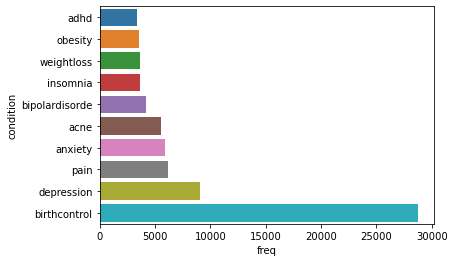

In [32]:
condition_freq = drugs_train.groupby('condition').count().reset_index().drop(['review','rating'], axis=1).rename(columns={'drugName':'freq'})
condition_freq_top10 = condition_freq.sort_values(by=['freq']).tail(10)
ax = sns.barplot(x="freq", y="condition", data=condition_freq_top10)
print('Percentage of data within th top 10', condition_freq_top10['freq'].sum()/condition_freq['freq'].sum())

Percentage of data within th top 10 0.20456055875308782


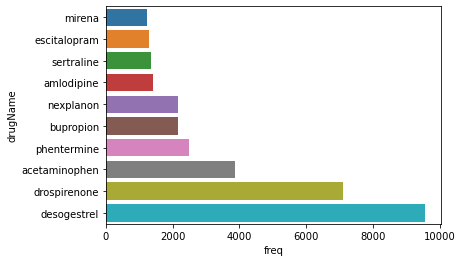

In [33]:
drug_freq = drugs_train.groupby('drugName').count().reset_index().drop(['review','rating'], axis=1).rename(columns={'condition':'freq'})
drug_freq_top10 = drug_freq.sort_values(by=['freq']).tail(10)
ax = sns.barplot(x="freq", y="drugName", data=drug_freq_top10)
print('Percentage of data within th top 10', drug_freq_top10['freq'].sum()/drug_freq['freq'].sum())